# Support Vector Machine Model
### Imports

In [2]:
import os
import json
import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import ParameterGrid

### Paths

In [3]:
DATA_DIR = "../data/splits"
MODEL_DIR = "../models/svm"
os.makedirs(MODEL_DIR, exist_ok=True)

TRAIN_PATH = f"{DATA_DIR}/train.csv"
VAL_PATH   = f"{DATA_DIR}/val.csv"
TEST_PATH  = f"{DATA_DIR}/test.csv"

TARGET_COL = "target"
SEED = 42

### Loading data

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]

X_val = val_df.drop(columns=[TARGET_COL])
y_val = val_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Train: (3096, 36)
Val  : (664, 36)
Test : (664, 36)


### SVM (RBF kernel)

In [5]:
svm_base = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=SEED
)

svm_base.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


### Validation Performance

In [6]:
val_preds = svm_base.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)

print("Validation Accuracy:", round(val_acc, 4))
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds))

Validation Accuracy: 0.6627

Classification Report (Validation):
              precision    recall  f1-score   support

     Dropout       0.78      0.51      0.62       213
    Enrolled       0.35      0.55      0.43       119
    Graduate       0.79      0.80      0.80       332

    accuracy                           0.66       664
   macro avg       0.64      0.62      0.61       664
weighted avg       0.71      0.66      0.67       664



### Hyperparameter Tuning

In [7]:
param_grid = {
    "C": [0.5, 1.0, 2.0],
    "gamma": ["scale", 0.1, 0.01]
}

best_acc = -1
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    model = SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=SEED,
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)

    if acc > best_acc:
        best_acc = acc
        best_params = params
        best_model = model

best_acc, best_params

(0.6626506024096386, {'C': 1.0, 'gamma': 'scale'})

In [8]:
with open(f"{MODEL_DIR}/best_params.json", "w") as f:
    json.dump(best_params, f, indent=2)

print("Saved best_params.json")

Saved best_params.json


### Test Evaluation

In [9]:
test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
cm = confusion_matrix(y_test, test_preds)

print("Test Accuracy:", round(test_acc, 4))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report (Test):")
print(classification_report(y_test, test_preds))

Test Accuracy: 0.7018

Confusion Matrix:
 [[126  65  23]
 [ 10  81  28]
 [ 10  62 259]]

Classification Report (Test):
              precision    recall  f1-score   support

     Dropout       0.86      0.59      0.70       214
    Enrolled       0.39      0.68      0.50       119
    Graduate       0.84      0.78      0.81       331

    accuracy                           0.70       664
   macro avg       0.70      0.68      0.67       664
weighted avg       0.76      0.70      0.72       664



### Saving Metrics

In [10]:
metrics = {
    "model": "SVM (RBF)",
    "accuracy": float(test_acc),
    "best_params": best_params,
    "confusion_matrix": cm.tolist(),
    "classification_report": classification_report(
        y_test, test_preds, output_dict=True
    )
}

with open(f"{MODEL_DIR}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics.json")

Saved metrics.json


### Confusion Matrix plot

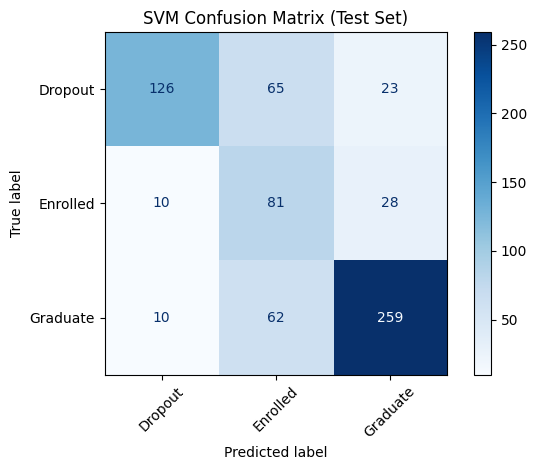

Saved confusion_matrix.png


In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("SVM Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/confusion_matrix.png")
plt.show()

print("Saved confusion_matrix.png")

### Saving Model

In [12]:
joblib.dump(best_model, f"{MODEL_DIR}/model.joblib")
print("Saved model.joblib")

Saved model.joblib
